# **<u>USE OF TWEEPY API: WERATEDOGS DATASET<u>**

## TABLE OF CONTENTS: <a id='toc'></a>

- [Connect to Twitter API](#twitter_connect)
- [Gather Data](#gather)
- [To Do List](#todo)
- [Assess Data](#assess)
- [Clean Data](#clean)
- [Prepare Visual](#prepviz)
- [Visual Heatmap preparation](#heatmap)
- [Drop-down menu heatmap](#ipywidget)
- [Concluding Remarks](#remarks)

In [1]:
# import respective libraries that will be used

import tweepy
import pandas as pd
import numpy as np
import requests
import json
import webbrowser #opens the redirect_url
import io #reads the request content
from bs4 import BeautifulSoup # to get href link
from timeit import default_timer as timer
from math import ceil # for preparing data to plot

#### CONNECT TO TWITTER API <a id='twitter_connect'></a>

In [2]:
API_KEY = 'XXXXX'
API_SECRET = 'XXXXX'

# OAuth 1a Authentication; pass key and secret to instaniate 
auth = tweepy.OAuthHandler(API_KEY, API_SECRET)

# Get a request token from twitter; Redirect user to twitter.com to authorize
redirect_url = auth.get_authorization_url()

In [3]:
# print link to passcode & open in browser
print(redirect_url) 
webbrowser.open(redirect_url)

In [4]:
# store pincode from user input
pin_number = input()

In [5]:
# get access token twitter
auth.get_access_token(pin_number)

In [6]:
# API class provides access to the entire twitter RESTful API methods; use wait limit of 15 mins
twapi = tweepy.API(auth, wait_on_rate_limit=True,\
                  wait_on_rate_limit_notify=True)

In [7]:
# test API
print(twapi.me().screen_name)

#### GATHER DATA <a id='gather'></a>

In [8]:
# read in tsv content using request library
tsv_img_pred_file = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
tsv_img_pred_content = requests.get(tsv_img_pred_file).content

In [9]:
# save to pandas df 
im_pred_df = pd.read_csv(io.StringIO(tsv_img_pred_content.decode('utf-8')),sep='\t')

# write to file to save
im_pred_df.to_csv('ts_img_pred_file.tsv', sep='\t')

In [10]:
# save main dataset from file into pandas df
df_twt = pd.read_csv('twitter-archive-enhanced.csv')

In [11]:
# define function to grab json data 'seems as though some tweet_ids are not valid anymore'
# save each tweet's returned JSON as a new line in a .txt file

def fetch_data():
    fails_dict = {}
    start = timer()
    with open('tweet_json.txt', 'w') as f:
        for i, twt_id in enumerate(df_twt['tweet_id']):
            print(str(i) + ": " + str(twt_id))
            try:
                fetch = twapi.get_status(twt_id, tweet_mode='extended')
                print("Success")
                json.dump(fetch._json, f)
                f.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[twt_id] = e
                pass
    end = timer()
    print(end - start)
    return fails_dict

In [12]:
#fails_dict = fetch_data()

In [13]:
#fails_dict

In [14]:
# create the third dataframe from the json file

row_list = []
with open('tweet_json.txt') as f:
    for line in f:
        jdata = json.loads(line)
        row_list.append([jdata['id_str'], 
                         jdata['retweet_count'],
                         jdata['favorite_count']])
        
df3_twt = pd.DataFrame(row_list, columns=['tweet_id', 'retweet_count', 'favourite_count'])

In [15]:
# copy the third dataframe
df3_twt_cp = df3_twt.copy()

# make copy of main df to alter/clean
df_twt_clean = df_twt.copy()

# make copy of img/pred df to alter/clean
df_img_pred_clean = im_pred_df.copy()

#### ASSESS DATA <a id='assess'></a>

In [16]:
# view head of img prediction dataframe
im_pred_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [17]:
# view head of archieved (file) dataframe 
df_twt.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [18]:
# view head of third dataframe from json file
df3_twt.head()

,tweet_id,retweet_count,favourite_count
0,892420643555336193,7654,35965
1,892177421306343426,5653,31050
2,891815181378084864,3750,23364
3,891689557279858688,7819,39274
4,891327558926688256,8416,37506


In [19]:
df3_twt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
tweet_id           2329 non-null object
retweet_count      2329 non-null int64
favourite_count    2329 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


In [20]:
df_twt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [21]:
im_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
df_twt[~df_twt.in_reply_to_status_id.isnull()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [23]:
df_twt.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
605        1
1446       1
1869       1
2091       1
2038       1
1940       1
1764       2
2310       2
1761       2
1920       2
2246       2
2237       2
2349       2
2326       2
2079       2
2305       3
1249       3
1898       3
1478       3
1692       3
2202       3
765        3
1928       3
1314       3
2183       3
        ... 
866       14
83        14
291       15
285       15
55        17
1663      20
516       24
1712      26
763       27
1433      44
1274      45
1202      50
1351      60
340       75
695       75
1254      80
433       84
1843      88
1228      99
1635     121
1634     143
1779     144
902      165
290      182
1120     204
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

## TO DO LIST: <a id='todo'></a>

### tidiness issues:

- in twitter archive dataset dog type category should be one column 
- merge all three datasets into one
- timestamp should not have +000 at end and turn into timestamp datatype

### quality issues:

- retweeted_status_id should be string
- retweeted_user_id should be string
- retweeted_status_ts should be timestamp type
- source should be url format; without `<a>` tag
- tweet id should be string
- in_reply_to_status_id should be string
- in_reply_to_user_id should be string
- tweet_id in img_pred df should be string to merge
- source text can be separate column 
- change dog stages to NaN not None
- change dog type in img_pred_df to lowercase for consistency
- some names are not valid, i.e. 'a'
- rating denominator not always 10; adjust values to 10
- change datatype of of numerator and denominator to float in order to divide
- Bo dog is a duplicate (but tweet id is different)

#### CLEAN DATA <a id='clean'></a>

##### alter source column and remove a tag

In [24]:
# define function to extract the href from the `<a>` tag

def extract_atag(html_link):
    soup = BeautifulSoup(html_link, "html.parser")
    try:
        href = soup.find('a').get('href')
    except AttributeError:
        href = float('nan')
    try:
        text = soup.text
    except Exception:
        text = float('nan')
    return href, text

In [25]:
# create two separate columns for the href link and the a-tag text
df_twt_clean = df_twt_clean.merge(df_twt_clean['source'].apply(
    lambda row: pd.Series( extract_atag(row) ) ), left_index=True, right_index=True )

# rename the new columns
df_twt_clean.rename({0: 'source_href', 1: 'source_text'}, axis='columns', inplace=True)

# then drop original column
df_twt_clean.drop('source', axis=1, inplace=True)

##### change datatypes

In [26]:
#  retweet status id should be string
df_twt_clean['retweeted_status_id'] = df_twt_clean['retweeted_status_id'].astype(str)

In [27]:
# tweet id should be string (df_twt_clean)
df_twt_clean['tweet_id'] = df_twt_clean['tweet_id'].astype(str)

In [28]:
# tweet id should be string (img_pred_df)
df_img_pred_clean['tweet_id'] = df_img_pred_clean['tweet_id'].astype(str)

In [29]:
# retweet user id should be string 
df_twt_clean['retweeted_status_user_id'] = df_twt_clean['retweeted_status_user_id'].astype(str)

In [30]:
# strip +0000 from string and convert to timestamp
df_twt_clean['timestamp'] = pd.to_datetime(df_twt_clean['timestamp'].str.replace("+0000", "", regex=False))

In [31]:
# in reply user id should be string 
df_twt_clean['in_reply_to_user_id'] = df_twt_clean['in_reply_to_user_id'].astype(str)

In [32]:
# in reply status id should be string 
df_twt_clean['in_reply_to_status_id'] = df_twt_clean['in_reply_to_status_id'].astype(str)

##### adjust ratings

In [33]:
# adjust the ratings values that have non-10 denominators

def adjust_denom(numer, denom):
    if denom != 10:
        if denom != 0:
            denom_adjust = denom/10
            new_numer = numer/denom_adjust 
        else:
            new_numer = numer + 10
        return round(new_numer,2), 10
    else:
        return numer, denom

In [34]:
# loop thru both columns and change their values if non-10 denominator
for i, (nm, dm) in enumerate(zip(df_twt_clean.rating_numerator, df_twt_clean.rating_denominator)):
    df_twt_clean.at[i, 'rating_numerator'], df_twt_clean.at[i, 'rating_denominator'] = adjust_denom(nm, dm)

In [35]:
# adjust datatype to float since some are decimal now
df_twt_clean.rating_denominator = df_twt_clean.rating_denominator.astype(float)
df_twt_clean.rating_numerator = df_twt_clean.rating_numerator.astype(float)

##### handle names issue

In [36]:
# clean names; some are not actual names they are words, replace with NaN

no_names=[]
for n in df_twt_clean.name:
    try:
        if not n[0].isupper() or n == "None" or len(n) < 3:
            no_names.append(n)
    except TypeError:
        pass

for i,n in enumerate(df_twt_clean.name):
    if n in no_names:
        df_twt_clean.at[i,'name'] = float('nan')

##### consoldiate dog stage into one column

In [37]:
# replace None with blank or NaN with blank for dog stage
def remove_none():
    for ds in ['doggo', 'puppo', 'floofer', 'pupper']:
        df_twt_clean[ds].replace('None', '', inplace=True)
        df_twt_clean[ds].replace(np.NaN, '', inplace=True)
        
remove_none()

In [38]:
# some text classifies the dog stage, extract and insert 
df_twt_clean['dog_stages'] = df_twt_clean.text.str.extract('(doggo|floofer|pupper|puppo)', expand = True)

In [39]:
#combine the dog stage values
df_twt_clean['dog_stages'] = df_twt_clean.doggo + df_twt_clean.floofer + df_twt_clean.pupper + df_twt_clean.puppo

In [40]:
# there are multiple dog stages for some
df_twt_clean.dog_stages.value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_stages, dtype: int64

In [41]:
# function to handle multiple dog stages
def correct_multi_dog_stages(dog_stage):
    if 'doggopupper' in dog_stage:
        return 'doggo, pupper'
    elif 'doggopuppo' in dog_stage:
        return 'doggo, puppo'
    elif 'doggofloofer' in dog_stage:
        return 'doggo, floofer'
    else:
        return dog_stage

In [42]:
# correct the multiple dog strings
df_twt_clean['dog_stages'] = df_twt_clean['dog_stages'].apply(lambda x: correct_multi_dog_stages(x))

In [43]:
# finally drop the 4 columns
df_twt_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace = True)

In [44]:
df_twt_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,source_href,source_text,dog_stages
0,892420643555336193,nan,nan,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,http://twitter.com/download/iphone,Twitter for iPhone,
1,892177421306343426,nan,nan,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,http://twitter.com/download/iphone,Twitter for iPhone,
2,891815181378084864,nan,nan,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,http://twitter.com/download/iphone,Twitter for iPhone,
3,891689557279858688,nan,nan,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,http://twitter.com/download/iphone,Twitter for iPhone,
4,891327558926688256,nan,nan,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,http://twitter.com/download/iphone,Twitter for iPhone,


In [45]:
df_twt_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null float64
name                          1487 non-null object
source_href                   2356 non-null object
source_text                   2356 non-null object
dog_stages                    2356 non-null object
dtypes: datetime64[ns](1), float64(2), object(12)
memory usage: 276.2+ KB


In [46]:
# make the dog names lower case for consistency

def lowercase_preds():
    for p in ['p1', 'p2', 'p3']:
        df_img_pred_clean[p] = df_img_pred_clean[p].apply(lambda x: x.lower())
        
lowercase_preds()

##### MERGE DATAFRAMES 

In [47]:
# merge all three
df_merge = df_twt_clean.merge(df3_twt_cp, on='tweet_id').merge(df_img_pred_clean, on='tweet_id')
df_merge.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,nan,nan,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,nan,nan,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,...,1,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,nan,nan,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,...,1,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,nan,nan,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,...,1,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,nan,nan,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,...,2,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True


In [48]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 28 columns):
tweet_id                      2057 non-null object
in_reply_to_status_id         2057 non-null object
in_reply_to_user_id           2057 non-null object
timestamp                     2057 non-null datetime64[ns]
text                          2057 non-null object
retweeted_status_id           2057 non-null object
retweeted_status_user_id      2057 non-null object
retweeted_status_timestamp    72 non-null object
expanded_urls                 2057 non-null object
rating_numerator              2057 non-null float64
rating_denominator            2057 non-null float64
name                          1370 non-null object
source_href                   2057 non-null object
source_text                   2057 non-null object
dog_stages                    2057 non-null object
retweet_count                 2057 non-null int64
favourite_count               2057 non-null int64
jpg_url             

##### Save data to sqlite3 database

In [49]:
import sqlite3
from sqlite3 import Error

# create function to connect to (or create a db file)
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
        return conn
    except Error as e:
        print(e)

            
# create sql table
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
# delete sql table
def delete_table(conn, table_name):
    sql_query = f'DELETE FROM {table_name}'
    cur = conn.cursor()
    cur.execute(sql_query)
    conn.commit()
    
# drop table
def drop_table(conn, table_name):
    sql_query = f'DROP TABLE {table_name}'
    cur = conn.cursor()
    cur.execute(sql_query)
    conn.commit()

In [50]:
# sql query to generate two tables (1) clean dataset and (2) for plot dataset

sql_create_projects_table = """ CREATE TABLE IF NOT EXISTS clean_data_table (
                                        tweet_id text PRIMARY KEY,
                                        in_reply_to_status_id text,
                                        in_reply_to_user_id text,
                                        timestamp timestamp,
                                        text text,
                                        retweeted_status_user_id text,
                                        retweeted_status_id text,
                                        retweeted_status_timestamp timestamp,
                                        expanded_urls text,
                                        rating_numerator real,
                                        rating_denominator real,
                                        name text,
                                        source_href text,
                                        source_text text,
                                        dog_stages text,
                                        retweet_count integer,
                                        favourite_count integer,
                                        jpg_url text,
                                        img_num integer,
                                        p1 text,
                                        p1_conf real,
                                        p1_dog text,
                                        p2 text,
                                        p2_conf real,
                                        p2_dog text,
                                        p3 text,
                                        p3_conf real,
                                        p3_dog text
                                    ); """

sql_create_tasks_table = """ CREATE TABLE IF NOT EXISTS plot_data_table (
                                    tweet_id text PRIMARY KEY,
                                    name text NOT NULL,
                                    retweet_count integer,
                                    favourite_count integer,
                                    text text,
                                    jpg_url text,
                                    rating real,
                                    rating_string text,
                                    pred_dog text,
                                    dog_stage text,
                                    pseudo_rows text,
                                    pseudo_cols text,
                                    dog_boolean text,
                                    date timestamp
                                ); """

In [51]:
# function to create or wipe sql table

def crdl_table(create=True):
    if conn is not None:
        # create tables
        if create:
            create_table(conn, sql_create_projects_table)
            create_table(conn, sql_create_tasks_table)
            
        else:
            delete_table(conn, 'clean_data_table')
            delete_table(conn, 'plot_data_table')
            print('Wiped sql tables')
    else:
        print("Error encountered trying to create table")
    # close connection afterwards
    conn.close()

In [52]:
# dictionary to select dog breed based on image prediction; if value is 4 will default to the first prediction, p1
pred_dog_dict = {1 : 'p1', 2 : 'p2', 3 : 'p3', 4: 'p1'}

In [53]:
# generate new dataframe for visualisation extracting select columns from df_merge

data_list = []
for i, r in df_merge.iterrows():
    try:
        idx_nbr = pred_dog_dict[r['img_num']]
        pred_dog = r[idx_nbr]
        rating = r['rating_numerator']/r['rating_denominator']
        
        data_list.append([r['tweet_id'],
                         r['name'],
                         r['retweet_count'],
                         r['favourite_count'],
                         r['text'],
                         r['jpg_url'],
                         rating,
                         "{}/{}".format(int(r['rating_numerator']),int(r['rating_denominator'])),
                         pred_dog,
                         r['dog_stages'],
                         r[f'{idx_nbr}_dog'],
                         r['timestamp'].strftime("%Y-%b-%d") 
                         ])
    except Exception as e:
        print(f'{i} - | {e}')
    
    
plot_df = pd.DataFrame(data_list, columns=['tweet_id','name','retweet_count',
                                           'favourite_count','text','jpg_url',
                                           'rating','rating_string',
                                           'pred_dog','dog_stage', 'dog_boolean',
                                           'date']) 

##### PREPARE HEATMAP DATA <a id='prepviz'></a>

In [54]:
# select best heatmap dimensions
row_cnt = 17 
col_cnt = ceil(plot_df.shape[0]/row_cnt)

In [55]:
# check to make sure the rows and columns match the dataset shape
col_cnt*row_cnt == plot_df.shape[0]

True

In [56]:
# sort the dataframe based on the rating
plot_df = plot_df.sort_values(by=['rating'], ascending=[False])

In [57]:
# create pseudo values for the rows and columns for each cell of the heatmap
def generate_pseudo_vals():
    list_pseudo_rows = [[f'r{i}']*row_cnt for i in range(col_cnt)]
    list_pseudo_rows = [item for sublist in list_pseudo_rows for item in sublist] # list within list
    list_pseudo_cols = [f'c{i}' for i in range(row_cnt)]*col_cnt
    return list_pseudo_rows, list_pseudo_cols

In [58]:
# Prepare to feed dataframe into Bokeh's ColumnDataSource class

plot_df['pseudo_rows'], plot_df['pseudo_cols'] = generate_pseudo_vals()

# replace with None if empty for dog stage
for cols in ['name', 'dog_stage']:
    plot_df[cols] = plot_df[cols].apply(lambda x: "None" if x=="" or pd.isna(x) else x) 

In [59]:
# make index start at 1
plot_df.index = np.arange(1, len(plot_df)+1)

In [60]:
plot_df.head()

,tweet_id,name,retweet_count,favourite_count,text,jpg_url,rating,rating_string,pred_dog,dog_stage,dog_boolean,date,pseudo_rows,pseudo_cols
1,749981277374128128,Atticus,2455,5104,This is Atticus. He's quite simply America af....,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,177.6,1776/10,bow_tie,None,False,2016-Jul-04,r0,c0
2,670842764863651840,None,8251,23590,After so many requests... here you go.\n\nGood...,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,42.0,420/10,microphone,None,False,2015-Nov-29,r0,c1
3,786709082849828864,Logan,6198,18465,"This is Logan, the Chow who lived. He solemnly...",https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,7.5,75/10,pomeranian,None,True,2016-Oct-13,r0,c2
4,810984652412424192,Sam,1459,5404,Meet Sam. She smiles 24/7 &amp; secretly aspir...,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,3.4,34/10,golden_retriever,None,True,2016-Dec-19,r0,c3
5,778027034220126208,Sophie,1626,6593,This is Sophie. She's a Jubilant Bush Pupper. ...,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,2.7,27/10,clumber,pupper,True,2016-Sep-20,r0,c4


In [61]:
# upload plot_df dataframe to sqlite3 database 

#change table_name based on needs
table_name ='plot_data_table'

#try:
#    conn = create_connection('twitter_wrangle.db')
#    plot_df.to_sql(name = table_name, con=conn, if_exists='append',index=False)
#except Exception as e:
#    print('error occured: %s' % e)
#finally:
#    conn.close()

In [62]:
# sort plot_df by favourite count as new dataframe
fav_df = plot_df.sort_values(by=['favourite_count'], ascending=[False])
fav_df.reset_index(inplace=True, drop=True)
fav_df['pseudo_rows'], fav_df['pseudo_cols'] = generate_pseudo_vals()
fav_df.head()

,tweet_id,name,retweet_count,favourite_count,text,jpg_url,rating,rating_string,pred_dog,dog_stage,dog_boolean,date,pseudo_rows,pseudo_cols
0,744234799360020481,None,77186,155227,Here's a doggo realizing you can stand in a po...,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1.3,13/10,labrador_retriever,doggo,True,2016-Jun-18,r0,c0
1,822872901745569793,None,43507,132304,Here's a super supportive puppo participating ...,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1.3,13/10,lakeland_terrier,puppo,True,2017-Jan-21,r0,c1
2,807106840509214720,Stephan,56239,119872,This is Stephan. He just wants to help. 13/10 ...,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1.3,13/10,chihuahua,None,True,2016-Dec-09,r0,c2
3,866450705531457537,Jamesy,32696,115819,This is Jamesy. He gives a kiss to every other...,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,1.3,13/10,boston_bull,pupper,True,2017-May-22,r0,c3
4,739238157791694849,None,57307,114725,Here's a doggo blowing bubbles. It's downright...,https://pbs.twimg.com/ext_tw_video_thumb/73923...,1.3,13/10,eskimo_dog,doggo,True,2016-Jun-04,r0,c4


In [63]:
# sort based on rewteet counts

retwt_df = plot_df.sort_values(by = ['retweet_count'], ascending=[False])
retwt_df['pseudo_rows'], retwt_df['pseudo_cols'] = generate_pseudo_vals()
retwt_df.reset_index(inplace=True, drop=True)

In [64]:
retwt_df.head()

,tweet_id,name,retweet_count,favourite_count,text,jpg_url,rating,rating_string,pred_dog,dog_stage,dog_boolean,date,pseudo_rows,pseudo_cols
0,744234799360020481,None,77186,155227,Here's a doggo realizing you can stand in a po...,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1.3,13/10,labrador_retriever,doggo,True,2016-Jun-18,r0,c0
1,739238157791694849,None,57307,114725,Here's a doggo blowing bubbles. It's downright...,https://pbs.twimg.com/ext_tw_video_thumb/73923...,1.3,13/10,eskimo_dog,doggo,True,2016-Jun-04,r0,c1
2,807106840509214720,Stephan,56239,119872,This is Stephan. He just wants to help. 13/10 ...,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1.3,13/10,chihuahua,None,True,2016-Dec-09,r0,c2
3,822872901745569793,None,43507,132304,Here's a super supportive puppo participating ...,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1.3,13/10,lakeland_terrier,puppo,True,2017-Jan-21,r0,c3
4,879415818425184262,Duddles,40325,98711,This is Duddles. He did an attempt. 13/10 some...,https://pbs.twimg.com/ext_tw_video_thumb/87941...,1.3,13/10,english_springer,None,True,2017-Jun-26,r0,c4


##### BOKEH VISUALISATION <a id='heatmap'></a>

In [65]:
# import the bokeh libraries

from bokeh.transform import transform
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool, LogColorMapper, LinearColorMapper, ColorBar, FuncTickFormatter, FixedTicker, BasicTicker, PrintfTickFormatter
from bokeh.io import output_notebook, reset_output, push_notebook  # enables plot interface in J notebook
import ipywidgets # for interactivity
import seaborn as sns
output_notebook()

Loading BokehJS ...

In [66]:
# make a log-scale range of the ratings column
bin_vals = np.geomspace(1e-2, plot_df.rating.max(),10).tolist()

In [67]:
# find closest value compared to a list of values (bin_vals) and return index
def closest_idx(lst, K):       
    close_val = lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    return bin_vals.index(close_val)

In [68]:
# colour map for the heatmap
colour_palette = ['#E8E8EB', '#FFF4E8', '#FFE0A3', '#FFCC66', '#FFB739', '#FF7D29', '#FF6600', '#A0AEC1', '#627894', '#336699'] 

In [69]:
# add hex colour code column for heatmap colour assignment (only for the rating metric, other metrics used ColorMapper methods from Bokeh)
plot_df['colour'] = plot_df.rating.apply(lambda x : colour_palette[closest_idx(bin_vals, x)])

In [70]:
# function that generates colour mapping based on different dataframe selected; will accommodate for log scale or linear scale 

def map_colours(df, metric, log_scale=True):
    if log_scale:
        # manually set ticks for unique rating system
        fixed_ticks = [1.35, 2.1, 3.6, 6, 9.7, 17.35, 30, 50, 80, 136]
        metric_range = [0, 0.5, 1, 1.4, 2, 8, 20, 40, 90, 170]
        
        # log scale colour map
        mapper = LogColorMapper(palette=colour_palette, low=df[metric].min(), high=df[metric].max())
        ticker = FixedTicker(ticks=fixed_ticks)
        
        # create a dictionary of the position on the colorbar and the value
        label_dict = {}
        for i, l in zip(fixed_ticks,metric_range):
            label_dict[i] = l 

        # custom formatter
        formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
        """ % label_dict)
        
        # format colour bar
        colour_bar = ColorBar(color_mapper=mapper, ticker=ticker, location=(0,0),
                             padding=1, formatter = formatter, major_tick_out=2,
                             major_tick_in=4, major_label_text_align='left',
                             major_label_text_font_size='10pt', label_standoff=1)

    else:
        # if not using log scale (linear) for retweet/favourite metric
        mapper = LinearColorMapper(palette=colour_palette, low=df[metric].min(), high=df[metric].max())
        ticker=BasicTicker(desired_num_ticks=len(colour_palette))
        colour_bar = ColorBar(color_mapper=mapper, formatter = PrintfTickFormatter(format="%d"), ticker=ticker, location=(0,0),
                             padding=1, major_tick_out=2,
                             major_tick_in=4, major_label_text_align='left',
                             major_label_text_font_size='10pt', label_standoff=1)
    

    
    return mapper, colour_bar  

In [71]:
# widget
drop_down = ipywidgets.Dropdown(options=['rating', 'retweet_count', 'favourite_count'],
                                value='rating',
                                description='Rank Metric:')

In [72]:
# create custom hovertool tip

hover = HoverTool(
        tooltips="""
        
        <table>
              <tr>
                <td "width=40%"> 
                    <div>
                        <img
                            src="@jpg_url" alt="@jpg_url" style="float: right; 
                            display: block;
                            max-width:550px;
                            max-height:350px;
                            width: auto;
                            height: auto;
                            margin: 0px 5px 5px 0px;
                            border:1px;"
                        /img>
                    </div>
                </td>
              
                <td style="text-align:left; float:left; 
                            word-wrap: break-word; 
                            width: 275px;">
            
                <div>
                    <span style="font-size: 10px;">Name: </span>
                    <span style="font-size: 12px; font-weight: bold;">@name</span>
                    <span style="font-size: 12px; color: #966;"> | #:@index</span>
                </div>

                <div>
                    <span style="font-size: 10px;">Rating:</span>
                    <span style="font-size: 10px; color: #696;">@rating_string (@rating)</span>
                </div>

                <div>
                    <span style="font-size: 10px;">Predict:</span>
                    <span style="font-size: 10px; color: #696;">@pred_dog</span>
                </div>

                <div>
                    <span style="font-size: 10px;">Dog Stage:</span>
                    <span style="font-size: 10px; color: #696;">@dog_stage</span>
                </div>

                <div>
                    <span style="font-size: 10px;">Tweet:</span>
                    <span style="font-size: 10px; color: #696;">@text</span>
                </div>

                <div>
                    <span style="font-size: 10px;">Favouite Count:</span>
                    <span style="font-size: 10px; color: #696;">@favourite_count</span>
                </div>

                <div>
                    <span style="font-size: 10px;">Retweet Count:</span>
                    <span style="font-size: 10px; color: #696;">@retweet_count</span>
                </div>

                <div>
                    <span style="font-size: 10px;">Tweet ID:</span>
                    <span style="font-size: 10px; color: #696;">@tweet_id</span>
                </div>
                
                <div>
                    <span style="font-size: 10px;">Dog boolean:</span>
                    <span style="font-size: 10px; color: #696;">@dog_boolean</span>
                </div>
                
                <div>
                    <span style="font-size: 10px;">Date: </span>
                    <span style="font-size: 10px; color: #696;">@date</span>
                </div>
                
            </td>
          </tr>
        </div>
    </table>
        """
    )

In [73]:
# Define a callback function: update_plot (re-plots based on new mapping and dataframe)
def update_plot(select):
    if select == 'retweet_count':
        source = ColumnDataSource(retwt_df)
        mapper, colour_bar = map_colours(retwt_df, select, False)
        mapper = transform(select, mapper)
        title = select.replace("_"," ")
        
    elif select == 'favourite_count':
        source = ColumnDataSource(fav_df)
        mapper, colour_bar = map_colours(fav_df, select, False)
        mapper = transform(select, mapper)
        title = select.replace("_"," ")
        
    else:
        source = ColumnDataSource(plot_df)
        mapper, colour_bar = map_colours(plot_df, select)
        mapper = 'colour'
        title =  'rounded and divided number resulting from the unique rating system'
        
    plot = plot_hm(source, title, mapper, colour_bar)    
    show(plot, notebook_handle=True)
    push_notebook()

In [74]:
# define function that inputs the dataframe into the bokeh ColumnDataSource object 
# and then input title, mapper, colour_bar to return the figure

def plot_hm(source, title, mapper, colour_bar):
    p = figure(tools=[hover],
               title="@WeRateDogs ratings heatmap: Colour bar on the right represents %s " % title,
               x_range=[f'r{i}' for i in range(col_cnt)],
               y_range=[f'c{i}' for i in range(row_cnt-1, -1, -1)],
               sizing_mode='stretch_width')

    p.rect('pseudo_rows','pseudo_cols' , source=source, width=1, height=1,
           line_color="#c9c6c5", fill_color=mapper,
           line_width=0.5)
    p.toolbar.logo = None
    p.add_layout(colour_bar, 'right')
    p.min_border_top = 150 #in order for the hover menu to show up properly for top row
    p.min_border_left = 25
    p.min_border_right = 25
    p.axis.visible = False
    p.x_range.range_padding = 0
    p.toolbar.autohide = True 
    p.grid.visible = False 

    return p

##### Plot the heatmap visual; select metric by the drop-down menu <a id='ipywidget'></a>

In [75]:
# interaction with drop-down menu
ipywidgets.interact(update_plot, select=drop_down)

interactive(children=(Dropdown(description='Rank Metric:', options=('rating', 'retweet_count', 'favourite_coun…

<function __main__.update_plot(select)>

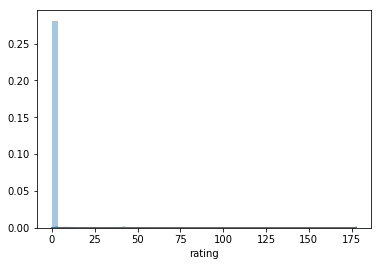

In [76]:
# show histogram of ratings
sns.distplot(plot_df.rating);

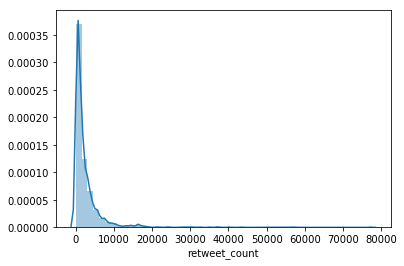

In [77]:
# show histogram of retweet counts
sns.distplot(plot_df.retweet_count);

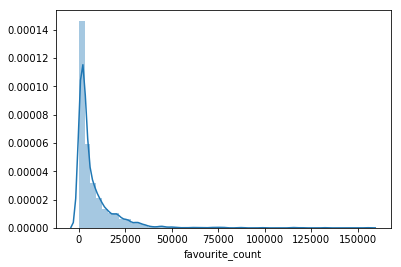

In [78]:
# show histogram of favourite counts
sns.distplot(plot_df.favourite_count);

### CONCLUDING REMARKS <a id='remarks'></a>

#### [Return to Table of Contents](#toc) 


##### Insights:

- From the heatmap and the histogram, it can be seen that many dogs were given average ratings even though the unique rating system seems to inflate most ratings, if one normalises it; it doesn't seem flattering anymore.
- The most highly rated dog is Atticus (177 or 1776/10) who is showing off our patriotic colours. The amount of retweets is, 2455 and favorite counts, 5104. However, the dog with the most retweets (77186) and favourite counts (155227) is an unnamed dog swimming in a pool. This dog's rating was just 1.3 (13/10).
- There are quite a few non-dog images in the dataset. Some of other types of animals and some of human beings. Some of the neural network predictions are off the mark. Some predictions show the image is a restaurant, although in fact it is an image of dogs inside a restaurant. Some images are phone screenshots of twitter or messaging apps so there will be no prediction and no name for that row of data.  